<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# convolutional variational autoencoder
!pip install tensorflow-probability
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
(train_images,_),(test_images,_ )  = tf.keras.datasets.mnist.load_data()
train_images.shape

(60000, 28, 28)

In [ ]:
train_images = tf.reshape(train_images,shape=(train_images.shape[0],28,28,1))/255
test_images = tf.reshape(test_images,shape=(test_images.shape[0],28,28,1))/255

In [ ]:
train_images.shape

TensorShape([60000, 28, 28, 1])

In [ ]:
train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [ ]:
# x = observation/input
# z = latent space

In [ ]:
# Encoder 
# encoder defines the distribution q(z/x), taking input as x and outputs a set of parameters
# specifying the conditional distribution (mean and the variance) of the latent space z

#the distribution q(z/x) of the latent z will be "modelled" as a diagonal gaussian  
#and the encoder outputs the mean, and the log variance parameters of the gaussian

# note that the mean and the variance will be multi dimensional
# also "diagonal gaussian" is a simplified version of multi dimensional gaussian distribution


# Decoder
# decoder defines the conditional distribution p(x/z) which takes as input a latent sample z  
# and outputs the random variables  for a conditional distribution of the observation x



In [ ]:
class VAE(tf.keras.Model):
  def __init__(self,latent_units):
    super(VAE,self).__init__()
    self.latent_units = latent_units
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(28,28,1)), # 28x28x1
      tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=(2,2),padding="same",activation='relu'), # 13x13x32
      tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(2,2),padding="same",activation="relu"), # 6x6x64
      tf.keras.layers.Flatten(), # bsz,6x6x64
      tf.keras.layers.Dense(units=16,activation="relu"),
      tf.keras.layers.Dense(units=self.latent_units + self.latent_units) # one for mean, one for diagonal variance
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(self.latent_units,)), # sampled z 
      tf.keras.layers.Dense(units=7*7*64, activation='relu'),
      tf.keras.layers.Reshape(target_shape=(7,7,64)),
      tf.keras.layers.Conv2DTranspose(
          filters=64, kernel_size=3, strides=2, padding='same',
          activation='relu'),
      tf.keras.layers.Conv2DTranspose(
          filters=32, kernel_size=3, strides=2, padding='same',
          activation='relu'),
      # No activation
      tf.keras.layers.Conv2DTranspose(
          filters=1, kernel_size=3, strides=1, padding='same',activation="sigmoid"),
    ])
  def encode(self,x): # encode the image into the mean and var of z
    mean, log_var = tf.split(self.encoder(x), num_or_size_splits=2, axis=1) # spit into mean and log variance
    return mean,log_var
  def reparameterize(self,mean,log_var): # reparameterization trick
    epsilon = tf.random.normal(shape=log_var.shape) # stochastic variable
    return mean + epsilon*tf.exp(log_var*0.5) # mean + std*eps
  def decode(self,z):
    return self.decoder(z) # got the image back

  @tf.function # making a static graph for faster computation
  def sample(self,epsilon=None): # once training has been done, sampling form z's distribution to generate new images
    if epsilon is None:
      epsilon = tf.random.normal(shape=(100,self.latent_units)) # sample 100 z's (i.e. the bsz = 100)
    return self.decode(epsilon) # generate new images from samples


In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model,x,beta=1):
  mean, log_var = model.encode(x) # encode
  z = model.reparameterize(mean, log_var)# sample
  x_recovered = model.decode(z) # deocode
  reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x,x_recovered)) # mean batch loss
  # z_decoded = K.flatten(z_decoded)
  # xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
  # kl_loss = -5e-4 * K.mean(
  # 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  # return K.mean(xent_loss + kl_loss)

  reconstruction_loss *= 28 * 28 # some scaling (for what ?)
  kl_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
  kl_loss = tf.reduce_mean(kl_loss)
  kl_loss *= -0.5
  total_loss = reconstruction_loss + beta*kl_loss # total loss
  return total_loss


In [ ]:
@tf.function# creating a static graph for faster performance
def train_step(model,x,optimizer):
  with tf.GradientTape() as tape:
    total_loss = compute_loss(model,x,beta=1)
  trainable_parameters = model.trainable_variables
  gradients = tape.gradient(total_loss, trainable_parameters)
  optimizer.apply_gradients(zip(gradients,trainable_parameters))
  return total_loss




In [ ]:
epochs = 10
latent_dim = 2 # dimensionality of latent space is 2 for ease of visualization, i.e. a 2 dimensional pdf
num_examples_val = 16 # for validation
epsilon_val = tf.random.normal(shape=(num_examples_val, latent_dim))


In [ ]:
val_input(epsilon_val)

In [ ]:
model = VAE(latent_dim)

In [ ]:
def try_(img):
  new = model.sample(img)

  fig = plt.figure(figsize=(4,4))
  for i in range(new.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(new[i,:,:,0],cmap="gray")
    plt.axis('off')
  plt.show()


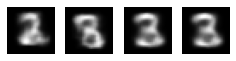

In [ ]:


epsilon_val=np.array([[0.1,-.9927954],[0.30048432,-.627954],[0.01048432,-.627954],[0.02648432,-.627954]])
try_(epsilon_val)

In [ ]:
t = epsilon_val[0][0]
kk = t+tf.random.normal(shape=(10,))/100
kk
print(epsilon_val)
print(kk)

tf.Tensor([[ 0.00348432 -0.627954  ]], shape=(1, 2), dtype=float32)
tf.Tensor(
[ 0.0035119   0.00774735 -0.00302929  0.00456769  0.00495275 -0.00966777
  0.00528862 -0.00116919  0.00366375  0.01639869], shape=(10,), dtype=float32)


In [ ]:
def val_generated(model, epoch, test_sample):
  mean, log_var = model.encode(test_sample)
  z = model.reparameterize(mean, log_var)
  reconstructed = model.sample(z)

  fig = plt.figure(figsize=(4,4))
  for i in range(reconstructed.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(reconstructed[i,:,:,0],cmap="gray")
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))


  
def val_input(test_sample):
  fig = plt.figure(figsize=(4,4))
  for i in range(test_sample.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(test_sample[i,:,:,0],cmap="gray")
    plt.axis("off")
  plt.show()


In [ ]:

assert batch_size >= num_examples_val
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_val,:,:,:]

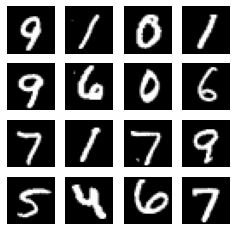

In [ ]:
val_input(test_sample)

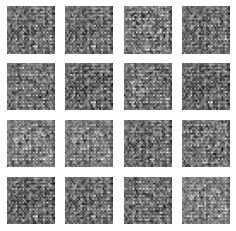

In [ ]:
val_generated(model,0,test_sample)

Epoch 1: Train Loss --> 415826.25, Val Loss--> 57346.921875


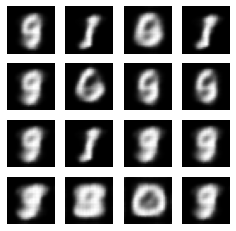

Epoch 2: Train Loss --> 327046.09375, Val Loss--> 52801.1015625


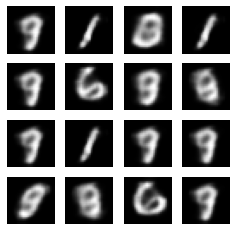

Epoch 3: Train Loss --> 310287.6875, Val Loss--> 50760.88671875


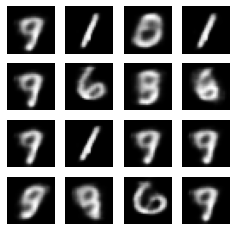

Epoch 4: Train Loss --> 301493.6875, Val Loss--> 49626.9921875


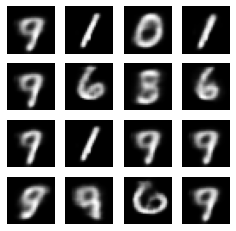

Epoch 5: Train Loss --> 296508.15625, Val Loss--> 49009.4375


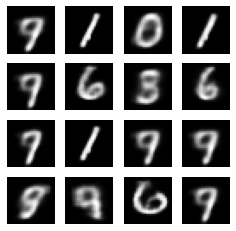

Epoch 6: Train Loss --> 293427.03125, Val Loss--> 48571.0390625


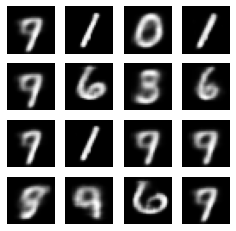

Epoch 7: Train Loss --> 291316.21875, Val Loss--> 48334.52734375


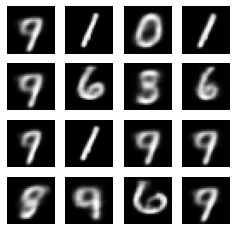

Epoch 8: Train Loss --> 289742.6875, Val Loss--> 48081.14453125


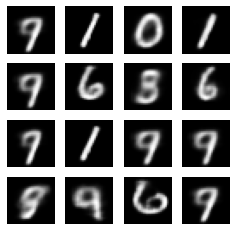

Epoch 9: Train Loss --> 288436.34375, Val Loss--> 47992.2109375


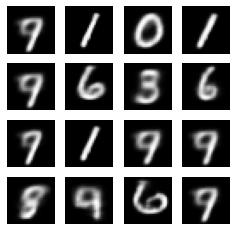

Epoch 10: Train Loss --> 287366.125, Val Loss--> 47819.8046875


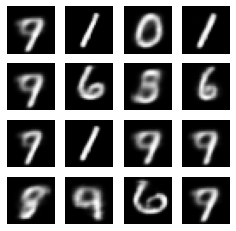

In [ ]:
train_losses = []
val_losses = []

for epoch in range(1,epochs+1):
  train_loss = 0
  for train_x in train_dataset:
    train_loss += train_step(model, train_x, optimizer)
  train_losses.append(train_loss)
  val_loss = 0
  for test_x in test_dataset:
    val_loss += compute_loss(model,test_x)
  val_losses.append(val_loss)
  print(f"Epoch {epoch}: Train Loss --> {train_loss}, Val Loss--> {val_loss}")
  val_generated(model,epoch, test_sample)



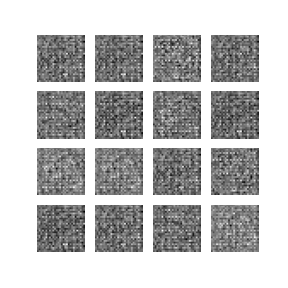

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()


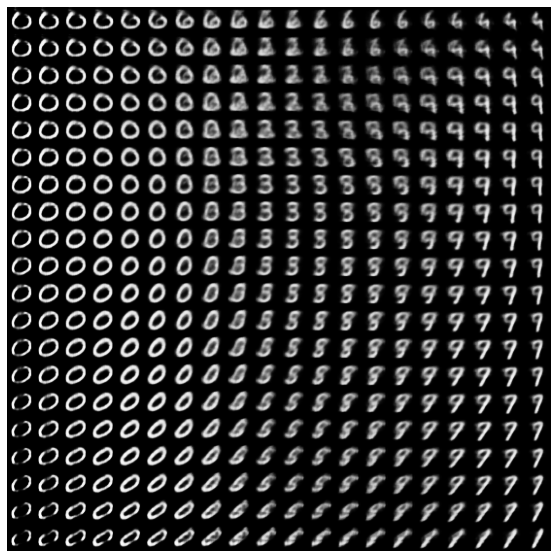

In [ ]:
plot_latent_images(model, 20)

In [ ]:
def plot_label_clusters(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = model.encode(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

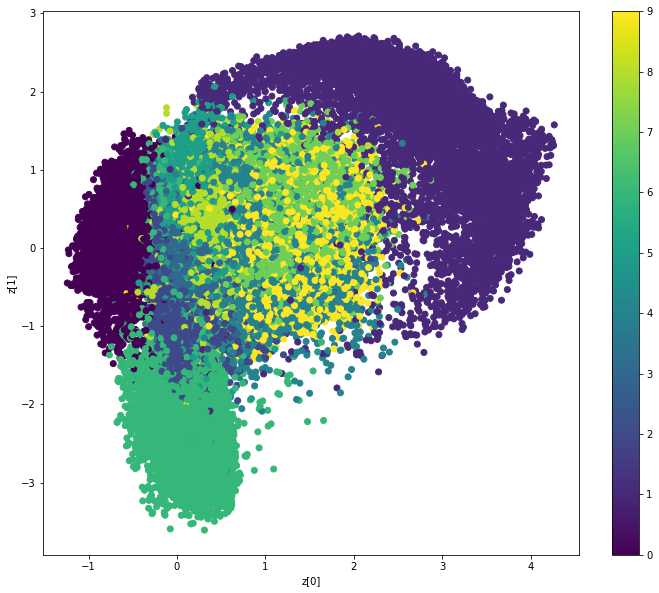

In [ ]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(model,x_train, y_train)